In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
cd /content/drive/'My Drive'/Code/Tracking

/content/drive/My Drive/Code/Tracking


In [3]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7MB 78kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [4]:
from __future__ import division, print_function, absolute_import
import cv2 as cv
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
sys.path
sys.path.append('./yolo')
from DetectorYolo3 import DetectorYolo3_CPU

from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from tools import generate_detections as gdet

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Instructions for updating:
non-resource variables are not supported in the long term


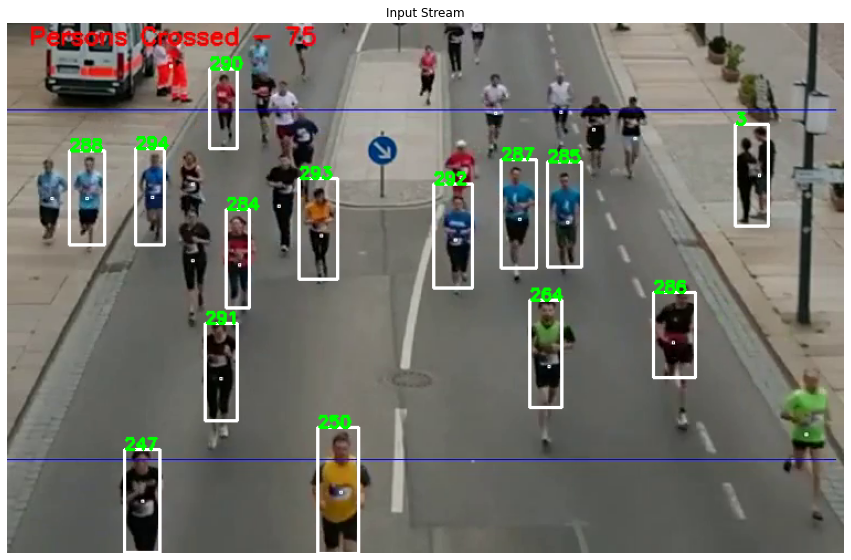

In [ ]:
vin="./videos/running.mp4"  

## Create a detector
configPath = "./yolo/yolov3-tiny.cfg"
weightPath = "./yolo/yolov3-tiny.weights"
metaPath = "./yolo/coco.data"
classPath="./yolo/coco.names" 
confThr=0.25
nmsThr=0.6
detector=DetectorYolo3_CPU(configPath,weightPath,classPath)

## Create a tracker (deep_sort )
max_cosine_distance = 0.3
nn_budget = None
nms_max_overlap = 1.0
model_filename = 'mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)
metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
tracker = Tracker(metric)

# Create a video cap
cap = cv.VideoCapture(vin)
frameW=int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frameH=int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

count=0
while True:
  ret, frame = cap.read()  # frame shape 640*480*3
  if ret != True:
    break;
  count +=1
  if count%2==1:
    boxs=detector.predict(frame,'person',0.25,0.4,32,64)
    for b in boxs:
      b[2]=b[2]-b[0]
      b[3]=b[3]-b[1]
    features = encoder(frame,boxs)
    
    # score to 1.0 here).
    detections = [Detection(bbox, 1.0, feature) for bbox, feature in zip(boxs, features)]
    
    # Run non-maxima suppression.
    boxes = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    indices = preprocessing.non_max_suppression(boxes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]
    
    # Call the tracker
    tracker.predict()
    tracker.update(detections)
    
    ##### Show track result
    for track in tracker.tracks:
      if not track.is_confirmed() or track.time_since_update > 1:
        continue
      bbox = track.to_tlbr()
      cv.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(255,255,255), 2)
      cv.putText(frame, str(track.track_id),(int(bbox[0]), int(bbox[1])),0, 5e-3 * 100, (0,255,0),2)
    
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    clear_output(wait=True)
    plt.figure(figsize=(15,10))
    plt.axis('off')
    plt.title("Input Stream")
    plt.imshow(frame)
    plt.show()
cap.release()